In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

import auxiliaries as aux

## Setup

In [2]:
# Develop window for data separation
species = 'Deer'
file_name = 'GSM02927'

years_to_predict = 1
time_intervals = 3 if species == 'Moose' else 4

regressive_window = aux.RegressiveWindow(species, file_name)
reversed_regressive_window = aux.ReversedRegressiveWindow(species, file_name)

results = {}

print('------Original Regressive Window------')
print(f'Original Data Size: {len(regressive_window.orig_df)}')
print(f'Training Data Size: {len(regressive_window.train_df)}')
print(f'Testing Data Size: {len(regressive_window.test_df)}\n')

print(f'Training Mean:\n{regressive_window.train_df.mean()}')
print(f'Training Std. Dev.:\n{regressive_window.train_df.std()}\n')

print('------Reversed Regressive Window------')
print(f'Original Data Size: {len(reversed_regressive_window.orig_df)}')
print(f'Training Data Size: {len(reversed_regressive_window.train_df)}')
print(f'Testing Data Size: {len(reversed_regressive_window.test_df)}\n')

print(f'Training Mean:\n{reversed_regressive_window.train_df.mean()}')
print(f'Training Std. Dev.:\n{reversed_regressive_window.train_df.std()}\n')

------Original Regressive Window------
Original Data Size: 2923
Training Data Size: 2046
Testing Data Size: 877

Training Mean:
external-temperature    16.545455
longitude               11.031551
latitude                46.008411
month                    6.251222
day                     15.697458
dtype: float64
Training Std. Dev.:
external-temperature    5.343885
longitude               0.021036
latitude                0.002235
month                   3.396595
day                     8.695606
dtype: float64

------Reversed Regressive Window------
Original Data Size: 2923
Training Data Size: 2046
Testing Data Size: 877

Training Mean:
external-temperature    15.382209
longitude               11.036021
latitude                46.008706
month                    6.727273
day                     15.601173
dtype: float64
Training Std. Dev.:
external-temperature    6.524474
longitude               0.018820
latitude                0.002072
month                   3.458438
day                  

### Regressive Model

In [3]:
regressive_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(1,3), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

regressive_window.model_compilation_and_fitting(regressive_model)

Epoch 1/20


c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7198 - mean_absolute_error: 0.6844 - mean_squared_error: 0.7198
Epoch 2/20
20/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5673 - mean_absolute_error: 0.5632 - mean_squared_error: 0.5673

c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error
  current = self.get_monitor_value(logs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5478 - mean_absolute_error: 0.5498 - mean_squared_error: 0.5478
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4882 - mean_absolute_error: 0.5125 - mean_squared_error: 0.4882
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4676 - mean_absolute_error: 0.5006 - mean_squared_error: 0.4676
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4891 - mean_absolute_error: 0.4989 - mean_squared_error: 0.4891
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4457 - mean_absolute_error: 0.4838 - mean_squared_error: 0.4457
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4250 - mean_absolute_error: 0.4627 - mean_squared_error: 0.4250
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4181 - mean_absolute_error: 0.4523 - mean_squared_error: 0.4181
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3889 - mean_absolute_error: 0.4343 - mean_squared_error: 0.3889
Epoch 10/20
64/64 ━

In [4]:
results['Original Regressive Model'] = regressive_model.evaluate(regressive_window.test_input, regressive_window.test_label, verbose=1, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9689 - mean_absolute_error: 0.7686 - mean_squared_error: 0.9689


In [5]:
# Generate CSV file analyzing testing set results
def graph_regressive(model, window, url_dest):
    test_df = window.test_df
    test_df['timestamp'] = window.timeline[int(len(window.orig_df)*0.7):]

    initial_df = test_df[['timestamp', 'month', 'day', 'external-temperature', 'longitude', 'latitude']]
    initial_df['id'] = ['original' for _ in range(len(initial_df))]

    data = {
        'timestamp': [],
        'month': [],
        'day': [],
        'external-temperature': [],
        'longitude': [],
        'latitude': [],
        'id': []
    }

    for i in range(len(initial_df)):
        section = initial_df.iloc[i]

        timestamp = section['timestamp']
        month = (section['month'] - window.train_df['month'].mean())/window.train_df['month'].std()
        day = (section['day'] - window.train_df['day'].mean())/window.train_df['day'].std()
        external_temp = (section['external-temperature'] - window.train_df['external-temperature'].mean())/window.train_df['external-temperature'].std()

        if isinstance(model, tf.keras.Sequential):
            output_fields = model(np.array([external_temp, month, day]).reshape([1, 1, 3])).numpy()*window.train_df[['longitude', 'latitude']].std().values + window.train_df[['longitude', 'latitude']].mean().values
            output_fields = output_fields[0][0]
        elif isinstance(model, sklearn.neighbors.KNeighborsRegressor):
            output_fields = model.predict([[external_temp, month, day]])[0]*window.train_df[['longitude', 'latitude']].std() + window.train_df[['longitude', 'latitude']].mean()
            output_fields = output_fields.values

        longitude = output_fields[0]
        latitude = output_fields[1]
        id = 'predicted'

        data['timestamp'].append(timestamp)
        data['month'].append(section['month'])
        data['day'].append(section['day'])
        data['external-temperature'].append(section['external-temperature'])
        data['longitude'].append(longitude)
        data['latitude'].append(latitude)
        data['id'].append(id)

    add_on_df = pd.DataFrame(data)
    
    full_df = pd.concat([initial_df, add_on_df], ignore_index=True)
    full_df.to_csv(url_dest, index=False)

    return full_df

regressive_test_results_df = graph_regressive(regressive_model, regressive_window, f'CSVFiles/TestPerformanceCSV/{species}/{file_name}_regressive_EdgeAnalysis.csv')

C:\Users\Imper\AppData\Local\Temp\ipykernel_24464\2546189966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['timestamp'] = window.timeline[int(len(window.orig_df)*0.7):]
C:\Users\Imper\AppData\Local\Temp\ipykernel_24464\2546189966.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df['id'] = ['original' for _ in range(len(initial_df))]


In [6]:
regressive_test_results_df

,timestamp,month,day,external-temperature,longitude,latitude,id
0,2007-10-19 16:02:55,10,19,-0.6,11.047242,46.010533,original
1,2007-10-19 20:01:47,10,19,-3.6,11.048442,46.008974,original
2,2007-10-20 00:01:11,10,20,11.4,11.047115,46.009779,original
3,2007-10-20 04:00:55,10,20,-7.3,11.048017,46.008876,original
4,2007-10-20 08:00:55,10,20,-8.0,11.046749,46.009134,original
...,...,...,...,...,...,...,...
1749,2008-03-14 16:00:54,3,14,4.4,11.039105,46.010988,predicted
1750,2008-03-14 20:01:53,3,14,4.7,11.039411,46.011028,predicted
1751,2008-03-15 00:03:05,3,15,3.8,11.037130,46.010809,predicted
1752,2008-03-15 04:02:21,3,15,1.0,11.032727,46.010445,predicted


In [7]:
important_columns = set(regressive_test_results_df.columns)
important_columns.remove('timestamp')
important_columns.remove('id')

normed_regressive_test_results = regressive_test_results_df.copy(deep=True)
normed_regressive_test_results[list(important_columns)] = (regressive_test_results_df[list(important_columns)] - regressive_window.train_df[list(important_columns)].mean())/regressive_window.train_df[list(important_columns)].std()
normed_regressive_test_results

,timestamp,month,day,external-temperature,longitude,latitude,id
0,2007-10-19 16:02:55,1.103687,0.379794,-3.208425,0.745921,0.949381,original
1,2007-10-19 20:01:47,1.103687,0.379794,-3.769815,0.802952,0.251817,original
2,2007-10-20 00:01:11,1.103687,0.494795,-0.962868,0.739851,0.611964,original
3,2007-10-20 04:00:55,1.103687,0.494795,-4.462195,0.782739,0.207699,original
4,2007-10-20 08:00:55,1.103687,0.494795,-4.593186,0.722471,0.323497,original
...,...,...,...,...,...,...,...
1749,2008-03-14 16:00:54,-0.957200,-0.195209,-2.272776,0.359078,1.152796,predicted
1750,2008-03-14 20:01:53,-0.957200,-0.195209,-2.216637,0.373618,1.170586,predicted
1751,2008-03-15 00:03:05,-0.957200,-0.080208,-2.385054,0.265178,1.072729,predicted
1752,2008-03-15 04:02:21,-0.957200,-0.080208,-2.909018,0.055911,0.910132,predicted


In [8]:
# Defining Input and Output Labels
input_columns = ['month', 'day', 'external-temperature']
output_columns = ['longitude', 'latitude']

# Input ordering
original_output = normed_regressive_test_results[normed_regressive_test_results.id == 'original'][output_columns].values
original_output = original_output.reshape((original_output.shape[0], original_output.shape[-1]))
predicted_output = normed_regressive_test_results[normed_regressive_test_results.id == 'predicted'][output_columns].values
predicted_output = predicted_output.reshape((predicted_output.shape[0], predicted_output.shape[-1]))

# Statistics gathering
mae_values = list(mean_absolute_error(original_output, predicted_output, multioutput='raw_values'))
mae_values = {coord_name: coord_value for coord_name, coord_value in zip(['mae_longitude', 'mae_latitude'], mae_values)}

mse_values = list(mean_squared_error(original_output, predicted_output, multioutput='raw_values'))
mse_values = {coord_name: coord_value for coord_name, coord_value in zip(['mse_longitude', 'mse_latitude'], mse_values)}

# Apply statistics to results
results['Original Regressive Model'].update(mae_values)
results['Original Regressive Model'].update(mse_values)

In [9]:
results['Original Regressive Model']

{'loss': 0.8736576437950134,
 'mean_absolute_error': 0.7309972047805786,
 'mean_squared_error': 0.8736576437950134,
 'mae_longitude': 0.7219680139952848,
 'mae_latitude': 0.7400264787663792,
 'mse_longitude': 0.8781940501173608,
 'mse_latitude': 0.8691214613722508}

In [10]:
# Histogram for Distance Errors
distances = []
unnormed_original_output = regressive_test_results_df[regressive_test_results_df['id'] == 'original'][output_columns].values
unnormed_predicted_output = regressive_test_results_df[regressive_test_results_df['id'] == 'predicted'][output_columns].values

r = 3958.756 + 636/5280 # Average radius of Earth to sea level plus elevation of Trentino
for original_coord, predicted_coord in zip(unnormed_original_output, unnormed_predicted_output):
    curr_d = 2*r*math.asin(
        math.sqrt(
            ((1-math.cos(math.radians(predicted_coord[1] - original_coord[1]))) 
             + math.cos(math.radians(predicted_coord[1]))*math.cos(math.radians(original_coord[1]))*(1-math.cos(math.radians(predicted_coord[0] - original_coord[0]))))/2))
    distances.append(curr_d)

distance_df = pd.DataFrame({'Distances': distances, 'Timestamp': regressive_test_results_df[regressive_test_results_df.id == 'original']['timestamp']})
distance_df['Timestamp'] = pd.DatetimeIndex(distance_df['Timestamp'])

In [11]:
hist, bins = np.histogram(distances, bins=12, range=(0, 3), density=True)

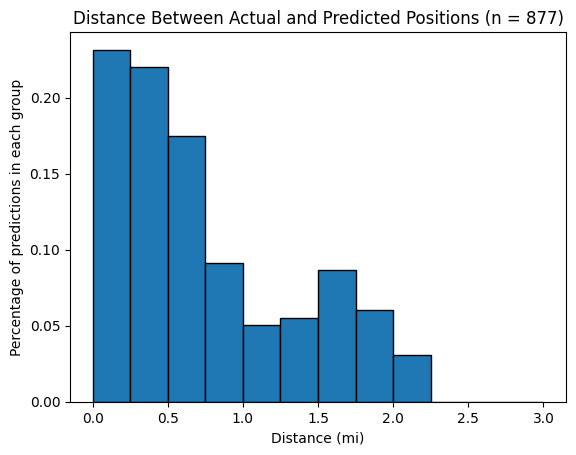

In [12]:
# Histogram of distances
con = plt.bar(bins[0:len(bins) - 1] + 0.125, hist*0.25, edgecolor='black', width=0.25)
plt.title(f"Distance Between Actual and Predicted Positions (n = {len(distances)})")
plt.xlabel("Distance (mi)")
plt.ylabel("Percentage of predictions in each group")
plt.show()

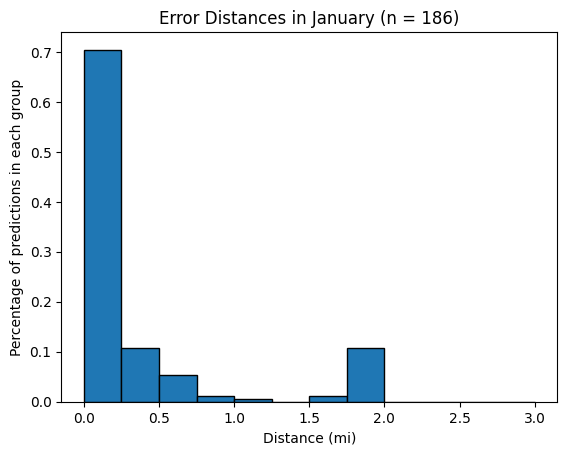

In [13]:
month = 'January'
month_to_date = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

hist, bins = np.histogram(distance_df[distance_df['Timestamp'].dt.month == month_to_date[month]]['Distances'].values, bins=12, range=(0, 3), density=True)

# Histogram of distances
con = plt.bar(bins[0:len(bins) - 1] + 0.125, hist*0.25, edgecolor='black', width=0.25)
plt.title(f"Error Distances in {month} (n = {len(distance_df[distance_df['Timestamp'].dt.month == month_to_date[month]]['Distances'].values)})")
plt.xlabel("Distance (mi)")
plt.ylabel("Percentage of predictions in each group")
plt.show()

In [14]:
regressive_window.csv_extension(f'{species}/{file_name}_regressive', species, regressive_model)

In [15]:
regressive_model.save(f'ModelFiles/SavedModels/{species}/{file_name}_regressive.keras')

### Reveresed Regressive

In [16]:
reversed_regressive_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=(1,3), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

reversed_regressive_window.model_compilation_and_fitting(reversed_regressive_model)

Epoch 1/20


c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7346 - mean_absolute_error: 0.6465 - mean_squared_error: 0.7346
Epoch 2/20
48/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4960 - mean_absolute_error: 0.4994 - mean_squared_error: 0.4960

c:\Users\Imper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error
  current = self.get_monitor_value(logs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4991 - mean_absolute_error: 0.5001 - mean_squared_error: 0.4991
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4711 - mean_absolute_error: 0.4777 - mean_squared_error: 0.4711
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4437 - mean_absolute_error: 0.4646 - mean_squared_error: 0.4437
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4213 - mean_absolute_error: 0.4517 - mean_squared_error: 0.4213
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4251 - mean_absolute_error: 0.4523 - mean_squared_error: 0.4251
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4414 - mean_absolute_error: 0.4541 - mean_squared_error: 0.4414
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3944 - mean_absolute_error: 0.4239 - mean_squared_error: 0.3944
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4005 - mean_absolute_error: 0.4271 - mean_squared_error: 0.4005
Epoch 10/20
64/64 ━

In [17]:
results['Reversed Regressive Model'] = reversed_regressive_model.evaluate(reversed_regressive_window.test_input, reversed_regressive_window.test_label, verbose=1, return_dict=True)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 2.3207 - mean_absolute_error: 1.2255 - mean_squared_error: 2.3207


In [18]:
reversed_regressive_test_results_df = graph_regressive(reversed_regressive_model, reversed_regressive_window, f'CSVFiles/TestPerformanceCSV/{species}/{file_name}_reversed_regressive_EdgeAnalysis.csv')

C:\Users\Imper\AppData\Local\Temp\ipykernel_24464\2546189966.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['timestamp'] = window.timeline[int(len(window.orig_df)*0.7):]
C:\Users\Imper\AppData\Local\Temp\ipykernel_24464\2546189966.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  initial_df['id'] = ['original' for _ in range(len(initial_df))]


In [19]:
reversed_regressive_test_results_df

,timestamp,month,day,external-temperature,longitude,latitude,id
0,2007-04-07 16:00:50,4,7,5.7,11.048319,46.010373,original
1,2007-04-07 12:01:42,4,7,5.0,11.048023,46.012476,original
2,2007-04-07 08:03:09,4,7,2.6,11.047479,46.011052,original
3,2007-04-07 04:00:53,4,7,2.6,11.046926,46.009605,original
4,2007-04-07 00:00:54,4,7,3.4,11.046919,46.010993,original
...,...,...,...,...,...,...,...
1749,2006-11-13 04:01:23,11,13,-4.2,11.047108,46.012274,predicted
1750,2006-11-13 00:02:24,11,13,-3.5,11.046931,46.012195,predicted
1751,2006-11-12 20:03:04,11,12,0.0,11.046814,46.011821,predicted
1752,2006-11-12 16:03:04,11,12,2.6,11.046538,46.011524,predicted


In [20]:
important_columns = set(reversed_regressive_test_results_df.columns)
important_columns.remove('timestamp')
important_columns.remove('id')

normed_reversed_regressive_test_results = reversed_regressive_test_results_df.copy(deep=True)
normed_reversed_regressive_test_results[list(important_columns)] = (reversed_regressive_test_results_df[list(important_columns)] - reversed_regressive_test_results_df[list(important_columns)].mean())/reversed_regressive_test_results_df[list(important_columns)].std()
normed_reversed_regressive_test_results

,timestamp,month,day,external-temperature,longitude,latitude,id
0,2007-04-07 16:00:50,-0.296204,-1.000470,1.574740,1.466157,0.387713,original
1,2007-04-07 12:01:42,-0.296204,-1.000470,1.396402,1.451968,1.401835,original
2,2007-04-07 08:03:09,-0.296204,-1.000470,0.784959,1.425868,0.714869,original
3,2007-04-07 04:00:53,-0.296204,-1.000470,0.784959,1.399361,0.017200,original
4,2007-04-07 00:00:54,-0.296204,-1.000470,0.988773,1.399045,0.686611,original
...,...,...,...,...,...,...,...
1749,2006-11-13 04:01:23,1.237012,-0.320218,-0.947464,1.408122,1.304411,predicted
1750,2006-11-13 00:02:24,1.237012,-0.320218,-0.769126,1.399613,1.266041,predicted
1751,2006-11-12 20:03:04,1.237012,-0.433593,0.122562,1.393986,1.085895,predicted
1752,2006-11-12 16:03:04,1.237012,-0.433593,0.784959,1.380755,0.942748,predicted


In [21]:
# Defining Input and Output Labels
input_columns = ['month', 'day', 'external-temperature']
output_columns = ['longitude', 'latitude']

# Input ordering
reversed_original_output = normed_reversed_regressive_test_results[normed_reversed_regressive_test_results.id == 'original'][output_columns].values
reversed_original_output = reversed_original_output.reshape((reversed_original_output.shape[0], reversed_original_output.shape[-1]))
reversed_predicted_output = normed_reversed_regressive_test_results[normed_reversed_regressive_test_results.id == 'predicted'][output_columns].values
reversed_predicted_output = reversed_predicted_output.reshape((reversed_predicted_output.shape[0], reversed_predicted_output.shape[-1]))

# Statistics gathering
mae_values = list(mean_absolute_error(reversed_original_output, reversed_predicted_output, multioutput='raw_values'))
mae_values = {coord_name: coord_value for coord_name, coord_value in zip(['mae_longitude', 'mae_latitude'], mae_values)}

mse_values = list(mean_squared_error(reversed_original_output, reversed_predicted_output, multioutput='raw_values'))
mse_values = {coord_name: coord_value for coord_name, coord_value in zip(['mse_longitude', 'mse_latitude'], mse_values)}

# Apply statistics to results
results['Reversed Regressive Model'].update(mae_values)
results['Reversed Regressive Model'].update(mse_values)

In [22]:
results['Reversed Regressive Model']

{'loss': 2.194957733154297,
 'mean_absolute_error': 1.1420971155166626,
 'mean_squared_error': 2.194957733154297,
 'mae_longitude': 0.8118092592617809,
 'mae_latitude': 1.3832267297188676,
 'mse_longitude': 1.3439743108976303,
 'mse_latitude': 2.7342080405696527}

In [23]:
# Histogram for Distance Errors
reversed_distances = []
unnormed_reversed_original_output = reversed_regressive_test_results_df[reversed_regressive_test_results_df['id'] == 'original'][output_columns].values
unnormed_reversed_predicted_output = reversed_regressive_test_results_df[reversed_regressive_test_results_df['id'] == 'predicted'][output_columns].values

r = 3958.756 + 636/5280 # Average radius of Earth to sea level plus elevation of Trentino
for original_coord, predicted_coord in zip(unnormed_reversed_original_output, unnormed_reversed_predicted_output):
    curr_d = 2*r*math.asin(
        math.sqrt(
            ((1-math.cos(math.radians(predicted_coord[1] - original_coord[1]))) 
             + math.cos(math.radians(predicted_coord[1]))*math.cos(math.radians(original_coord[1]))*(1-math.cos(math.radians(predicted_coord[0] - original_coord[0]))))/2))
    reversed_distances.append(curr_d)

reversed_distance_df = pd.DataFrame({'Distances': reversed_distances, 'Timestamp': reversed_regressive_test_results_df[reversed_regressive_test_results_df.id == 'original']['timestamp']})
reversed_distance_df['Timestamp'] = pd.DatetimeIndex(reversed_distance_df['Timestamp'])

In [24]:
hist, bins = np.histogram(reversed_distances, bins=12, range=(0,3), density=True)

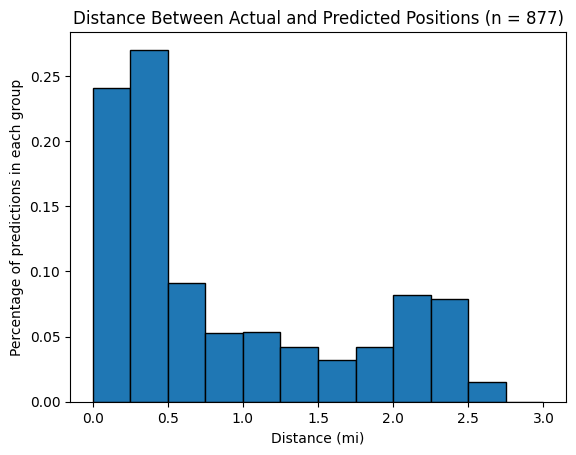

In [25]:
# Histogram of distances
con = plt.bar(bins[0:len(bins) - 1] + 0.125, hist*0.25, edgecolor='black', width=0.25)
plt.title(f"Distance Between Actual and Predicted Positions (n = {len(reversed_distances)})")
plt.xlabel("Distance (mi)")
plt.ylabel("Percentage of predictions in each group")
plt.show()

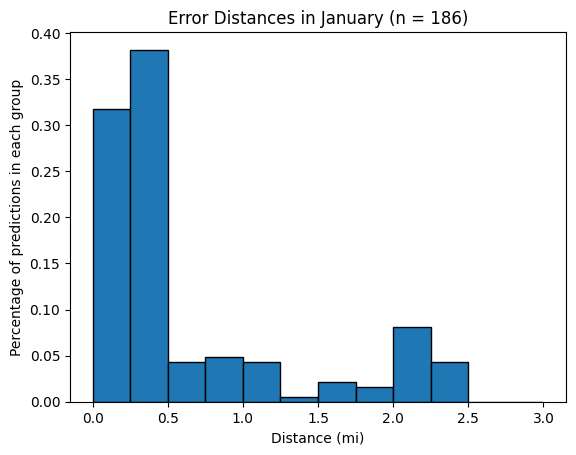

In [26]:
month = 'January'
month_to_date = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

hist, bins = np.histogram(reversed_distance_df[reversed_distance_df['Timestamp'].dt.month == month_to_date[month]]['Distances'].values, bins=12, range=(0, 3), density=True)

# Histogram of distances
con = plt.bar(bins[0:len(bins) - 1] + 0.125, hist*0.25, edgecolor='black', width=0.25)
plt.title(f"Error Distances in {month} (n = {len(reversed_distance_df[reversed_distance_df['Timestamp'].dt.month == month_to_date[month]]['Distances'].values)})")
plt.xlabel("Distance (mi)")
plt.ylabel("Percentage of predictions in each group")
plt.show()

In [27]:
reversed_regressive_window.csv_extension(f'{species}/{file_name}_reversed_regressive', species, reversed_regressive_model)

In [28]:
reversed_regressive_model.save(f'ModelFiles/SavedModels/{species}/{file_name}_reversed_regressive.keras')

### Final Results

In [29]:
results_df = pd.DataFrame(results).T
results_df.to_csv(f'ModelFiles/Statistics/{species}/{file_name}_test_data.csv', index_label='Model_Name')
results_df

,loss,mean_absolute_error,mean_squared_error,mae_longitude,mae_latitude,mse_longitude,mse_latitude
Original Regressive Model,0.873658,0.730997,0.873658,0.721968,0.740026,0.878194,0.869121
Reversed Regressive Model,2.194958,1.142097,2.194958,0.811809,1.383227,1.343974,2.734208
